In [9]:
from time import time, strftime, gmtime
import os
import numpy as np
from psychopy import visual, core, event
from pylsl import StreamInfo, StreamOutlet
from muselsl import record
from multiprocessing import Process
from stimulus_presentation import ssvep
from mne import Epochs, find_events
import sys
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt
from utils import utils

# SSVEP

This notebook will run an SSVEP to analyze visual evoked potentials. Flashing gratings of two different frequencies will be presented

## Step 1: Connect to an EEG Device

*Note: if using Windows 10 and BlueMuse, skip this section and connect using the BlueMuse GUI*

Make sure your device is turned on and run the following code. It should detect and connect to the device and begin 'Streaming...'

If the device is not found or the connection times out, try running this code again

In [ ]:
# Search for available Muse devices
muses = list_muses()

In [2]:
# Start a background process that will stream data from the first available Muse
stream_process = Process(target=stream, args=(muses[0]['address'],))
stream_process.start()

Flickering frequencies (Hz): [30.0, 20.0]

17.0287 	WARNING 	User requested fullscreen with size [1600  900], but screen is actually [1920, 1080]. Using actual size


## Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize
Put the Muse on and run the following code to view the raw EEG data stream.

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

In [ ]:
%matplotlib
view()

## Step 3: Run the Experiment
Modify the variables in the following code chunk to define how long you want to run the experiment and the name of the subject and session you are running. Then, seat the subject in front of the computer and have them quietly view the screen until the experiment is completed.

In [24]:
# Define these parameters 
duration = 120
subject = 1
session = 1

In [ ]:
recording_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", "SSVEP", "subject" + subject, "session" + session, ("recording_%s.csv" %
                                              strftime("%Y-%m-%d-%H.%M.%S", gmtime())) + ".csv")

stimulus = Process(target=ssvep.present, args=(duration,))
recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

## Step 5: Visualizing in the Frequency Domain

### Load data into MNE objects

In [28]:
raw = utils.load_data('visual/SSVEP', sfreq=256., 
                      subject_nb=subject, session_nb=session,
                      ch_ind=[0, 1, 2, 3, 4], 
                      replace_ch_names={'Right AUX': 'POz'})

Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.


### Power Spectral Density

One way to analyze the SSVEP is to plot the power spectral density, or PSD. SSVEPs should appear as peaks in power for certain frequencies. We expect clear peaks in the spectral domain at the stimulation frequencies of 30 and 20 Hz.

In [29]:
events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None, preload=True, 
                verbose=False, picks=[0, 1, 2, 3, 4])

197 events found
Event IDs: [1 2]


Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


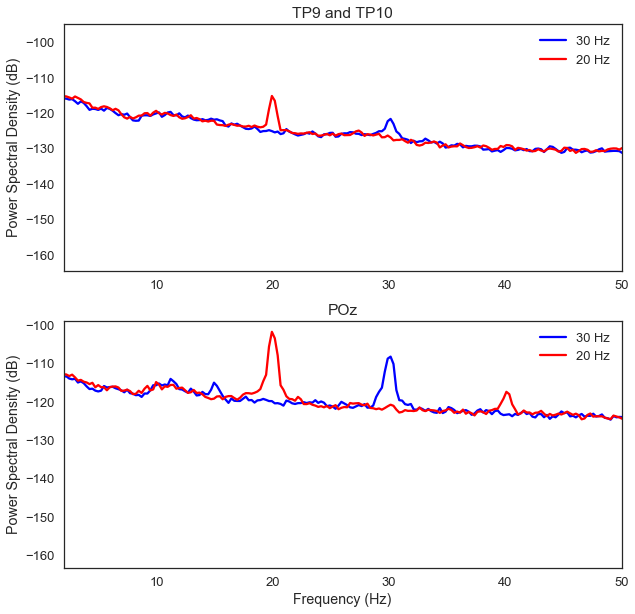

In [30]:
from mne.time_frequency import psd_welch

f, axs = plt.subplots(2, 1, figsize=(10, 10))
psd1, freq1 = psd_welch(epochs['30 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['20 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

axs[0].plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='30 Hz')
axs[0].plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='20 Hz')

axs[1].plot(freq1, psd1_mean[4, :], color='b', label='30 Hz')
axs[1].plot(freq2, psd2_mean[4, :], color='r', label='20 Hz')

axs[0].set_title('TP9 and TP10')
axs[1].set_title('POz')
axs[0].set_ylabel('Power Spectral Density (dB)')
axs[1].set_ylabel('Power Spectral Density (dB)')
axs[0].set_xlim((2, 50))
axs[1].set_xlim((2, 50))
axs[1].set_xlabel('Frequency (Hz)')
axs[0].legend()
axs[1].legend()

plt.show()

### Spectrogram
We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time

Applying baseline correction (mode: logratio)


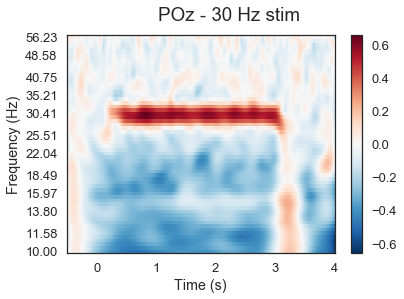

Applying baseline correction (mode: logratio)


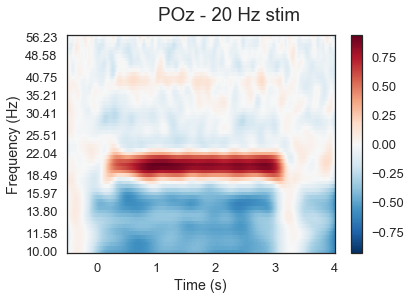

In [31]:
from mne.time_frequency import tfr_morlet

frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs['30 Hz'], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - 30 Hz stim');

tfr, itc = tfr_morlet(epochs['20 Hz'], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - 20 Hz stim');

### Raw Signal

Finally, we can see if the SSVEP is visible in the raw EEG signal.

### Filtering

We filter data between 2 and 50 Hz.

In [32]:
raw_filt = raw.copy().filter(5, 50, method='iir')

Setting up band-pass filter from 5 - 50 Hz
Setting up band-pass filter from 5 - 50 Hz
Setting up band-pass filter from 5 - 50 Hz
Setting up band-pass filter from 5 - 50 Hz
Setting up band-pass filter from 5 - 50 Hz
Setting up band-pass filter from 5 - 50 Hz


### Epoching

Here we epoch data for -100ms to 800ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs were the signal exceed 75 uV. This mainly rejects blinks.

In [33]:
events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}

epochs = Epochs(raw_filt, events=events, event_id=event_id, 
                tmin=-0.3, tmax=3, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0,4,2,3])

197 events found
Event IDs: [1 2]


### Epoch Average

c:\users\jdpig\miniconda3\envs\neurobrite\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


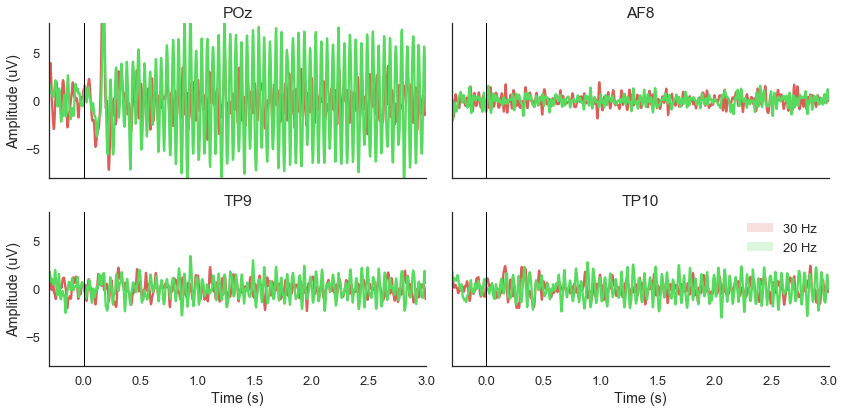

In [34]:
conditions = OrderedDict()
conditions['30 Hz'] = [1]
conditions['20 Hz'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1, title='',
                                diff_waveform=None, ylim=(-8, 8))